In [12]:
import urllib, os, sys, zipfile
from os.path import dirname
import numpy as np
import tensorflow as tf
from tensorflow.core.framework import graph_pb2
from tensorflow.python.tools.freeze_graph import freeze_graph
import tfcoreml
import inference_wrapper
import configuration
from coremltools.proto import NeuralNetwork_pb2
from PIL import Image

In [2]:
checkpoint_file = './trainlogIncNEW/model.ckpt-1000000'
pre_frozen_model_file = './frozen_model_memeceptionNEW.pb'
frozen_model_file = './frozen_model_memeceptionNEW.pb'
output_node_names = ['lstm/initial_state']
#output_node_names = ['softmax','lstm/state']
# output_node_names = ['lstm/split']
# original_output_node_names = ['softmax','lstm/state']
# input_node_names = ['image_feed', 'seq_embeddings','lstm/state_feed']
input_node_names = ['image_feed']
#input_node_names = ['seq_embeddings','lstm/state_feed']
beam_size = 2

In [3]:
# Build the inference graph.
g = tf.Graph()
with g.as_default():
    model = inference_wrapper.InferenceWrapper()
    restore_fn = model.build_graph_from_config(configuration.ModelConfig(),
                                               checkpoint_file)
g.finalize()

INFO:tensorflow:Building model.
About to decide if splitting
new_h Tensor("lstm/basic_lstm_cell/Mul_2:0", shape=(1, 512), dtype=float32)
new_state LSTMStateTuple(c=<tf.Tensor 'lstm/basic_lstm_cell/Add_1:0' shape=(1, 512) dtype=float32>, h=<tf.Tensor 'lstm/basic_lstm_cell/Mul_2:0' shape=(1, 512) dtype=float32>)
About to decide if splitting
It's splitting
new_h Tensor("lstm/basic_lstm_cell/Mul_5:0", shape=(1, 2, 512), dtype=float32)
new_state LSTMStateTuple(c=<tf.Tensor 'lstm/basic_lstm_cell/Add_3:0' shape=(1, 2, 512) dtype=float32>, h=<tf.Tensor 'lstm/basic_lstm_cell/Mul_5:0' shape=(1, 2, 512) dtype=float32>)
BUILDING DENSE
MATMUL(TENSORDOT) w/ SPLITTING


In [4]:
# Write the graph
tf_model_path = './log/pre_graph_memeceptionNEW.pb'
tf.train.write_graph(
    g,
    './log',
    'pre_graph_memeceptionNEW.pb',
    as_text=False,
)

with open(tf_model_path, 'rb') as f:
    serialized = f.read()
tf.reset_default_graph()
original_gdef = tf.GraphDef()
original_gdef.ParseFromString(serialized)

47082309

In [5]:
from tensorflow.python.tools import strip_unused_lib
from tensorflow.python.framework import dtypes
from tensorflow.python.platform import gfile

gdef = strip_unused_lib.strip_unused(
        input_graph_def = original_gdef,
        input_node_names = input_node_names,
        output_node_names = output_node_names,
        placeholder_type_enum = dtypes.float32.as_datatype_enum)
# Save it to an output file
with gfile.GFile(pre_frozen_model_file, 'wb') as f:
    f.write(gdef.SerializeToString())

In [6]:
# Call freeze graph
freeze_graph(input_graph=pre_frozen_model_file,
             input_saver='',
             input_binary=True,
             input_checkpoint=checkpoint_file,
             output_node_names=','.join(output_node_names),
             restore_op_name='save/restore_all',
             filename_tensor_name='save/Const:0',
             output_graph=frozen_model_file,
             clear_devices=True,
             initializer_nodes='')

INFO:tensorflow:Restoring parameters from ./trainlogIncNEW/model.ckpt-1000000
INFO:tensorflow:Froze 379 variables.
Converted 379 variables to const ops.


In [7]:
input_tensor_shapes = {
     'image_feed:0': [299, 299, 3],
    #'seq_embeddings:0': [1, beam_size, 300],
    #'lstm/state_feed:0': [1, beam_size, 1024],
}
coreml_model_file = './Memeception_NEW.mlmodel'
# output_tensor_names = ['softmax:0','lstm/state:0','lstm/initial_state:0']
# output_tensor_names = ['lstm/initial_state:0']
output_tensor_names = [node + ':0' for node in output_node_names]

In [8]:
# Call the converter
#output_feature_names = ['lstm/basic_lstm_cell/concat_2:0']

coreml_model = tfcoreml.convert(
        tf_model_path=frozen_model_file, 
        mlmodel_path=coreml_model_file, 
        input_name_shape_dict=input_tensor_shapes,
#         output_feature_names=output_feature_names + ['lstm/basic_lstm_cell/MatMul_1:0'],
        output_feature_names=output_tensor_names,
        image_input_names = ['image_feed:0'],
         red_bias = -1,
         green_bias = -1,
         blue_bias = -1,
         image_scale = 2.0/255.0
#         add_custom_layers=True,
#         custom_conversion_functions={
#             'lstm/split': _convert_split,
#             'lstm/basic_lstm_cell/split_1': _convert_lstmsplit,
#             'lstm/basic_lstm_cell/split': _convert_lstmsplit,
#         },
)

Shapes not found for 315 tensors. Executing graph to determine shapes. 
Automatic shape interpretation succeeded for input blob image_feed:0
1/1222: Analysing op name: image_feed ( type:  Placeholder )
Skipping name of placeholder
2/1222: Analysing op name: ExpandDims/dim ( type:  Const )
3/1222: Analysing op name: ExpandDims ( type:  ExpandDims )
4/1222: Analysing op name: InceptionV3/Conv2d_1a_3x3/weights ( type:  Const )
5/1222: Analysing op name: InceptionV3/Conv2d_1a_3x3/weights/read ( type:  Identity )
6/1222: Analysing op name: InceptionV3/InceptionV3/Conv2d_1a_3x3/Conv2D ( type:  Conv2D )
7/1222: Analysing op name: InceptionV3/InceptionV3/Conv2d_1a_3x3/BatchNorm/Const ( type:  Const )
8/1222: Analysing op name: InceptionV3/Conv2d_1a_3x3/BatchNorm/beta ( type:  Const )
9/1222: Analysing op name: InceptionV3/Conv2d_1a_3x3/BatchNorm/beta/read ( type:  Identity )
10/1222: Analysing op name: InceptionV3/Conv2d_1a_3x3/BatchNorm/moving_mean ( type:  Const )
11/1222: Analysing op name:

104/1222: Analysing op name: InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/weights/read ( type:  Identity )
105/1222: Analysing op name: InceptionV3/InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/Conv2D ( type:  Conv2D )
106/1222: Analysing op name: InceptionV3/InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/Const ( type:  Const )
107/1222: Analysing op name: InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/beta ( type:  Const )
108/1222: Analysing op name: InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/beta/read ( type:  Identity )
109/1222: Analysing op name: InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean ( type:  Const )
110/1222: Analysing op name: InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean/read ( type:  Identity )
111/1222: Analysing op name: InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance ( type:  Const )
112/1222: Analysing op name: InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance/r

178/1222: Analysing op name: InceptionV3/Mixed_5c/Branch_1/Conv_1_0c_5x5/weights ( type:  Const )
179/1222: Analysing op name: InceptionV3/Mixed_5c/Branch_1/Conv_1_0c_5x5/weights/read ( type:  Identity )
180/1222: Analysing op name: InceptionV3/InceptionV3/Mixed_5c/Branch_1/Conv_1_0c_5x5/Conv2D ( type:  Conv2D )
181/1222: Analysing op name: InceptionV3/InceptionV3/Mixed_5c/Branch_1/Conv_1_0c_5x5/BatchNorm/Const ( type:  Const )
182/1222: Analysing op name: InceptionV3/Mixed_5c/Branch_1/Conv_1_0c_5x5/BatchNorm/beta ( type:  Const )
183/1222: Analysing op name: InceptionV3/Mixed_5c/Branch_1/Conv_1_0c_5x5/BatchNorm/beta/read ( type:  Identity )
184/1222: Analysing op name: InceptionV3/Mixed_5c/Branch_1/Conv_1_0c_5x5/BatchNorm/moving_mean ( type:  Const )
185/1222: Analysing op name: InceptionV3/Mixed_5c/Branch_1/Conv_1_0c_5x5/BatchNorm/moving_mean/read ( type:  Identity )
186/1222: Analysing op name: InceptionV3/Mixed_5c/Branch_1/Conv_1_0c_5x5/BatchNorm/moving_variance ( type:  Const )
18

304/1222: Analysing op name: InceptionV3/InceptionV3/Mixed_5d/Branch_2/Conv2d_0c_3x3/BatchNorm/Const ( type:  Const )
305/1222: Analysing op name: InceptionV3/Mixed_5d/Branch_2/Conv2d_0c_3x3/BatchNorm/beta ( type:  Const )
306/1222: Analysing op name: InceptionV3/Mixed_5d/Branch_2/Conv2d_0c_3x3/BatchNorm/beta/read ( type:  Identity )
307/1222: Analysing op name: InceptionV3/Mixed_5d/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_mean ( type:  Const )
308/1222: Analysing op name: InceptionV3/Mixed_5d/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_mean/read ( type:  Identity )
309/1222: Analysing op name: InceptionV3/Mixed_5d/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance ( type:  Const )
310/1222: Analysing op name: InceptionV3/Mixed_5d/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance/read ( type:  Identity )
311/1222: Analysing op name: InceptionV3/InceptionV3/Mixed_5d/Branch_2/Conv2d_0c_3x3/BatchNorm/FusedBatchNorm ( type:  FusedBatchNorm )
312/1222: Analysing op name: InceptionV3/InceptionV3/Mix

402/1222: Analysing op name: InceptionV3/InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/Relu ( type:  Relu )
403/1222: Analysing op name: InceptionV3/Mixed_6b/Branch_1/Conv2d_0b_1x7/weights ( type:  Const )
404/1222: Analysing op name: InceptionV3/Mixed_6b/Branch_1/Conv2d_0b_1x7/weights/read ( type:  Identity )
405/1222: Analysing op name: InceptionV3/InceptionV3/Mixed_6b/Branch_1/Conv2d_0b_1x7/Conv2D ( type:  Conv2D )
406/1222: Analysing op name: InceptionV3/InceptionV3/Mixed_6b/Branch_1/Conv2d_0b_1x7/BatchNorm/Const ( type:  Const )
407/1222: Analysing op name: InceptionV3/Mixed_6b/Branch_1/Conv2d_0b_1x7/BatchNorm/beta ( type:  Const )
408/1222: Analysing op name: InceptionV3/Mixed_6b/Branch_1/Conv2d_0b_1x7/BatchNorm/beta/read ( type:  Identity )
409/1222: Analysing op name: InceptionV3/Mixed_6b/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean ( type:  Const )
410/1222: Analysing op name: InceptionV3/Mixed_6b/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean/read ( type:  Identity )
411/1222: An

478/1222: Analysing op name: InceptionV3/InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/Const ( type:  Const )
479/1222: Analysing op name: InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/beta ( type:  Const )
480/1222: Analysing op name: InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/beta/read ( type:  Identity )
481/1222: Analysing op name: InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_mean ( type:  Const )
482/1222: Analysing op name: InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_mean/read ( type:  Identity )
483/1222: Analysing op name: InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_variance ( type:  Const )
484/1222: Analysing op name: InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_variance/read ( type:  Identity )
485/1222: Analysing op name: InceptionV3/InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/FusedBatchNorm ( type:  FusedBatchNorm )
486/1222: Analysing op name: InceptionV3/InceptionV3/Mix

553/1222: Analysing op name: InceptionV3/InceptionV3/Mixed_6c/Branch_2/Conv2d_0a_1x1/BatchNorm/Const ( type:  Const )
554/1222: Analysing op name: InceptionV3/Mixed_6c/Branch_2/Conv2d_0a_1x1/BatchNorm/beta ( type:  Const )
555/1222: Analysing op name: InceptionV3/Mixed_6c/Branch_2/Conv2d_0a_1x1/BatchNorm/beta/read ( type:  Identity )
556/1222: Analysing op name: InceptionV3/Mixed_6c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean ( type:  Const )
557/1222: Analysing op name: InceptionV3/Mixed_6c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean/read ( type:  Identity )
558/1222: Analysing op name: InceptionV3/Mixed_6c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance ( type:  Const )
559/1222: Analysing op name: InceptionV3/Mixed_6c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance/read ( type:  Identity )
560/1222: Analysing op name: InceptionV3/InceptionV3/Mixed_6c/Branch_2/Conv2d_0a_1x1/BatchNorm/FusedBatchNorm ( type:  FusedBatchNorm )
561/1222: Analysing op name: InceptionV3/InceptionV3/Mix

640/1222: Analysing op name: InceptionV3/InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/Const ( type:  Const )
641/1222: Analysing op name: InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/beta ( type:  Const )
642/1222: Analysing op name: InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/beta/read ( type:  Identity )
643/1222: Analysing op name: InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean ( type:  Const )
644/1222: Analysing op name: InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean/read ( type:  Identity )
645/1222: Analysing op name: InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance ( type:  Const )
646/1222: Analysing op name: InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance/read ( type:  Identity )
647/1222: Analysing op name: InceptionV3/InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/FusedBatchNorm ( type:  FusedBatchNorm )
648/1222: Analysing op name: InceptionV3/InceptionV3/Mix

724/1222: Analysing op name: InceptionV3/InceptionV3/Mixed_6d/Branch_2/Conv2d_0e_1x7/BatchNorm/Const ( type:  Const )
725/1222: Analysing op name: InceptionV3/Mixed_6d/Branch_2/Conv2d_0e_1x7/BatchNorm/beta ( type:  Const )
726/1222: Analysing op name: InceptionV3/Mixed_6d/Branch_2/Conv2d_0e_1x7/BatchNorm/beta/read ( type:  Identity )
727/1222: Analysing op name: InceptionV3/Mixed_6d/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_mean ( type:  Const )
728/1222: Analysing op name: InceptionV3/Mixed_6d/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_mean/read ( type:  Identity )
729/1222: Analysing op name: InceptionV3/Mixed_6d/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_variance ( type:  Const )
730/1222: Analysing op name: InceptionV3/Mixed_6d/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_variance/read ( type:  Identity )
731/1222: Analysing op name: InceptionV3/InceptionV3/Mixed_6d/Branch_2/Conv2d_0e_1x7/BatchNorm/FusedBatchNorm ( type:  FusedBatchNorm )
732/1222: Analysing op name: InceptionV3/InceptionV3/Mix

799/1222: Analysing op name: InceptionV3/InceptionV3/Mixed_6e/Branch_2/Conv2d_0a_1x1/BatchNorm/Const ( type:  Const )
800/1222: Analysing op name: InceptionV3/Mixed_6e/Branch_2/Conv2d_0a_1x1/BatchNorm/beta ( type:  Const )
801/1222: Analysing op name: InceptionV3/Mixed_6e/Branch_2/Conv2d_0a_1x1/BatchNorm/beta/read ( type:  Identity )
802/1222: Analysing op name: InceptionV3/Mixed_6e/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean ( type:  Const )
803/1222: Analysing op name: InceptionV3/Mixed_6e/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean/read ( type:  Identity )
804/1222: Analysing op name: InceptionV3/Mixed_6e/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance ( type:  Const )
805/1222: Analysing op name: InceptionV3/Mixed_6e/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance/read ( type:  Identity )
806/1222: Analysing op name: InceptionV3/InceptionV3/Mixed_6e/Branch_2/Conv2d_0a_1x1/BatchNorm/FusedBatchNorm ( type:  FusedBatchNorm )
807/1222: Analysing op name: InceptionV3/InceptionV3/Mix

886/1222: Analysing op name: InceptionV3/InceptionV3/Mixed_7a/Branch_0/Conv2d_1a_3x3/BatchNorm/Const ( type:  Const )
887/1222: Analysing op name: InceptionV3/Mixed_7a/Branch_0/Conv2d_1a_3x3/BatchNorm/beta ( type:  Const )
888/1222: Analysing op name: InceptionV3/Mixed_7a/Branch_0/Conv2d_1a_3x3/BatchNorm/beta/read ( type:  Identity )
889/1222: Analysing op name: InceptionV3/Mixed_7a/Branch_0/Conv2d_1a_3x3/BatchNorm/moving_mean ( type:  Const )
890/1222: Analysing op name: InceptionV3/Mixed_7a/Branch_0/Conv2d_1a_3x3/BatchNorm/moving_mean/read ( type:  Identity )
891/1222: Analysing op name: InceptionV3/Mixed_7a/Branch_0/Conv2d_1a_3x3/BatchNorm/moving_variance ( type:  Const )
892/1222: Analysing op name: InceptionV3/Mixed_7a/Branch_0/Conv2d_1a_3x3/BatchNorm/moving_variance/read ( type:  Identity )
893/1222: Analysing op name: InceptionV3/InceptionV3/Mixed_7a/Branch_0/Conv2d_1a_3x3/BatchNorm/FusedBatchNorm ( type:  FusedBatchNorm )
894/1222: Analysing op name: InceptionV3/InceptionV3/Mix

961/1222: Analysing op name: InceptionV3/InceptionV3/Mixed_7b/Branch_1/Conv2d_0a_1x1/BatchNorm/Const ( type:  Const )
962/1222: Analysing op name: InceptionV3/Mixed_7b/Branch_1/Conv2d_0a_1x1/BatchNorm/beta ( type:  Const )
963/1222: Analysing op name: InceptionV3/Mixed_7b/Branch_1/Conv2d_0a_1x1/BatchNorm/beta/read ( type:  Identity )
964/1222: Analysing op name: InceptionV3/Mixed_7b/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean ( type:  Const )
965/1222: Analysing op name: InceptionV3/Mixed_7b/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean/read ( type:  Identity )
966/1222: Analysing op name: InceptionV3/Mixed_7b/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance ( type:  Const )
967/1222: Analysing op name: InceptionV3/Mixed_7b/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance/read ( type:  Identity )
968/1222: Analysing op name: InceptionV3/InceptionV3/Mixed_7b/Branch_1/Conv2d_0a_1x1/BatchNorm/FusedBatchNorm ( type:  FusedBatchNorm )
969/1222: Analysing op name: InceptionV3/InceptionV3/Mix

1035/1222: Analysing op name: InceptionV3/InceptionV3/Mixed_7b/Branch_2/Conv2d_0d_3x1/BatchNorm/Const ( type:  Const )
1036/1222: Analysing op name: InceptionV3/Mixed_7b/Branch_2/Conv2d_0d_3x1/BatchNorm/beta ( type:  Const )
1037/1222: Analysing op name: InceptionV3/Mixed_7b/Branch_2/Conv2d_0d_3x1/BatchNorm/beta/read ( type:  Identity )
1038/1222: Analysing op name: InceptionV3/Mixed_7b/Branch_2/Conv2d_0d_3x1/BatchNorm/moving_mean ( type:  Const )
1039/1222: Analysing op name: InceptionV3/Mixed_7b/Branch_2/Conv2d_0d_3x1/BatchNorm/moving_mean/read ( type:  Identity )
1040/1222: Analysing op name: InceptionV3/Mixed_7b/Branch_2/Conv2d_0d_3x1/BatchNorm/moving_variance ( type:  Const )
1041/1222: Analysing op name: InceptionV3/Mixed_7b/Branch_2/Conv2d_0d_3x1/BatchNorm/moving_variance/read ( type:  Identity )
1042/1222: Analysing op name: InceptionV3/InceptionV3/Mixed_7b/Branch_2/Conv2d_0d_3x1/BatchNorm/FusedBatchNorm ( type:  FusedBatchNorm )
1043/1222: Analysing op name: InceptionV3/Incept

1114/1222: Analysing op name: InceptionV3/InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/BatchNorm/Const ( type:  Const )
1115/1222: Analysing op name: InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/BatchNorm/beta ( type:  Const )
1116/1222: Analysing op name: InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/BatchNorm/beta/read ( type:  Identity )
1117/1222: Analysing op name: InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean ( type:  Const )
1118/1222: Analysing op name: InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean/read ( type:  Identity )
1119/1222: Analysing op name: InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance ( type:  Const )
1120/1222: Analysing op name: InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance/read ( type:  Identity )
1121/1222: Analysing op name: InceptionV3/InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/BatchNorm/FusedBatchNorm ( type:  FusedBatchNorm )
1122/1222: Analysing op name: InceptionV3/Incept

1200/1222: Analysing op name: lstm/basic_lstm_cell/kernel ( type:  Const )
1201/1222: Analysing op name: lstm/basic_lstm_cell/kernel/read ( type:  Identity )
1202/1222: Analysing op name: lstm/basic_lstm_cell/bias ( type:  Const )
1203/1222: Analysing op name: lstm/basic_lstm_cell/bias/read ( type:  Identity )
1204/1222: Analysing op name: lstm/basic_lstm_cell/Const ( type:  Const )
1205/1222: Analysing op name: lstm/basic_lstm_cell/concat/axis ( type:  Const )
1206/1222: Analysing op name: lstm/basic_lstm_cell/concat ( type:  ConcatV2 )
1207/1222: Analysing op name: lstm/basic_lstm_cell/MatMul ( type:  MatMul )
1208/1222: Analysing op name: lstm/basic_lstm_cell/BiasAdd ( type:  BiasAdd )
1209/1222: Analysing op name: lstm/basic_lstm_cell/split ( type:  Split )
1210/1222: Analysing op name: lstm/basic_lstm_cell/Sigmoid_1 ( type:  Sigmoid )
1211/1222: Analysing op name: lstm/basic_lstm_cell/Tanh ( type:  Tanh )
1212/1222: Analysing op name: lstm/basic_lstm_cell/Mul_1 ( type:  Mul )
1213

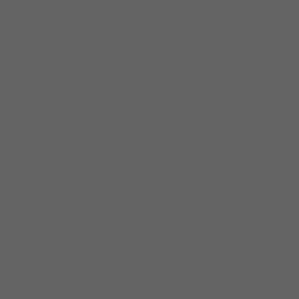

In [21]:
Image.fromarray(np.uint8(np.ones([299,299,3])*100))

In [22]:
np.random.seed(2)
#seq_embeddings = np.ones([300, 1, 2])
#state_feed = np.ones([1024, 1, 2])
image_feed = Image.fromarray(np.uint8(np.ones([299,299,3])*100)) #np.ones([3,299,299])
coreml_inputs = {
    #'#seq_embeddings__0': seq_embeddings,
    #'lstm__state_feed__0': state_feed,
    'image_feed__0': image_feed,
}
coreml_output = coreml_model.predict(coreml_inputs, useCPUOnly=True)
# print(coreml_output['lstm__state__0'].shape)
# print(coreml_output['softmax__0'].shape)
# print(coreml_output['softmax__0'].reshape(38521, 1, 2))
# print(coreml_output)
#print(coreml_output['lstm__state__0'].shape)
#print(coreml_output['softmax__0'].shape)
print(coreml_output['lstm__initial_state__0'][:10])

[ 1.00000000e+00 -1.19929510e-07 -1.00000000e+00  1.23859167e-28
 -1.00000000e+00 -1.00000000e+00  9.99984860e-01 -1.00000000e+00
 -9.53933442e-24  1.78964476e-24]


In [23]:
print(coreml_output['lstm__initial_state__0'][0])
print(coreml_output['lstm__initial_state__0'][-1])

1.0
4.6610498571908465e-08


In [ ]:
print(coreml_output['lstm__state__0'][:,:,:10,:,0])

In [ ]:
state_output = np.loadtxt('stateoutputTEST.txt')

In [ ]:
(state_output[1,:]==coreml_output['lstm__state__0'][0,0,:,0,1])[:50]

In [ ]:
print(state_output[0,377])
print(coreml_output['lstm__state__0'][0,0,377,0,0])

In [ ]:
img = np.moveaxis(np.asarray(image) / 256.0, [0, 1, 2], [1, 2, 0])

In [ ]:
coreml_model

In [ ]:
""" 'image_feed:0': [299, 299, 3],
    'seq_embeddings:0': [1, 1, 300],
    'lstm/state_feed:0': [1, 1024],
"""
coreml_inputs = {
    'image_feed__0': image,
#     'seq_embeddings__0': np.random.rand(300, 1, 1),
#     'lstm__state_feed__0': np.random.rand(1024),
}
coreml_output = coreml_model.predict(coreml_inputs, useCPUOnly=True)
print(list(coreml_output['lstm__initial_state__0'][:20]))

In [ ]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1000px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [ ]:
show_graph(gdef)

In [ ]:
embeddings_bytes = embeddings.flatten().tobytes()

In [ ]:
open('embeddings_bin.bin', 'wb').write(embeddings_bytes)

In [ ]:
import coremltools
read_model = coremltools.models.MLModel(coreml_model_file)
dir(read_model)

In [ ]:
import coremltools
def print_coreml_nn_layer_info(spec):
    nn_layers = coremltools.models.utils._get_nn_layers(spec)
    for i, layer in enumerate(nn_layers):
        if layer.WhichOneof('layer') == 'custom':
            print 'layer_id = ', i
            print layer
        else:
            print('{}: layer type: ({}) , inputs: {}, outputs: {}'.
              format(i,layer.WhichOneof('layer'), ", ".join([x for x in layer.input]), ", ".join([x for x in layer.output])))

print_coreml_nn_layer_info(coreml_model.get_spec())

In [ ]:
# Test the model!!!

import PIL
from IPython.core.display import Image

filename = '/Users/freedmand/Desktop/zelda_driving.jpg'
with tf.gfile.GFile(filename, "rb") as f:
  image = PIL.Image.open(f)
  image = image.resize([299,299], PIL.Image.ANTIALIAS)
    
display(Image(filename, width=299, height=299))